## Определение вида бабочки по изображению

In [ ]:
%%capture
!wget -O train.zip https://www.dropbox.com/scl/fi/bel6gt6vsb3onahlxvyjc/train_fix.zip?rlkey=q2wscp6wv9j2hbk07y1mbcm54&dl=0
!wget -O valid.zip https://www.dropbox.com/scl/fi/cwwblwhvqgwubb8a4xg90/valid.zip?rlkey=mow899lvyawq4wku2m8lfvrh3&dl=0

In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import re
import shutil

from sklearn.metrics import accuracy_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
zip = ZipFile('train.zip')
zip.extractall()

In [ ]:
zip = ZipFile('valid.zip')
zip.extractall()

In [ ]:
pattern = r"^(.+?)\s+\((\d+)\)\.[^.]+$"

In [ ]:
os.makedirs('/content/train', exist_ok=True)

for filename in os.listdir('/content/train/train'):
    file_path = os.path.join('/content/train/train', filename)

    if not os.path.isfile(file_path):
        continue

    match = re.match(pattern, filename)

    if match:
        name = match.group(1).strip().lower()
        number = match.group(2)

        name_dir = os.path.join('/content/train', name)
        os.makedirs(name_dir, exist_ok=True)

        extension = os.path.splitext(filename)[1]
        new_filename = f"{number}{extension}"
        new_file_path = os.path.join(name_dir, new_filename)

        shutil.copy2(file_path, new_file_path)
    else:
        print(f"Файл не соответствует шаблону: {filename}")

In [ ]:
shutil.rmtree('/content/train/train')

In [ ]:
data_dir = '/content/'
train_path = '/content/train'
test_path = '/content/test'

height = 112
width = 112
channels = 3

In [ ]:
data = []
labels = []
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

75

In [ ]:
for cat in os.listdir(train_path):
    path = os.path.join(train_path,cat)
    images = os.listdir(path)
    for a in images:
            image = Image.open(path + '/' + a)
            image = image.resize((height,width))
            image = np.array(image)
            data.append(image)
            labels.append(cat)

data = np.array(data)
labels = np.array(labels)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [ ]:
encoded_labels

array([16, 16, 16, ..., 40, 40, 40])

In [ ]:
print(data.shape,labels.shape)

X_train, X_test, Y_train, Y_test = train_test_split(data,encoded_labels,test_size=0.2,random_state=42, shuffle=True)

X_train = X_train/255
X_test = X_test/255

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(9285, 112, 112, 3) (9285,)
(7428, 112, 112, 3) (1857, 112, 112, 3) (7428,) (1857,)


In [ ]:
Y_train=keras.utils.to_categorical(Y_train,NUM_CATEGORIES)
Y_test= keras.utils.to_categorical(Y_test,NUM_CATEGORIES)

print(Y_train.shape)
print(Y_test.shape)

(7428, 75)
(1857, 75)


In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(height,width,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,860,075 (18.54 MB)

 Trainable params: 4,860,075 (18.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
aug = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, Y_test) )

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


233/233 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.0254 - loss: 4.2237 - val_accuracy: 0.1061 - val_loss: 3.5781
Epoch 2/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.1029 - loss: 3.5548 - val_accuracy: 0.2052 - val_loss: 3.0205
Epoch 3/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.1646 - loss: 3.2117 - val_accuracy: 0.3010 - val_loss: 2.6723
Epoch 4/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.2287 - loss: 2.9096 - val_accuracy: 0.3468 - val_loss: 2.3815
Epoch 5/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.2741 - loss: 2.6342 - val_accuracy: 0.4023 - val_loss: 2.2070
Epoch 6/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.3350 - loss: 2.4500 - val_accuracy: 0.3958 - val_loss: 2.0983
Epoch 7/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.3631 - loss: 2.2762 - val_accuracy: 0.4841 - val_loss: 1.8178
Epoch 8/15
233/233 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.4057 - loss: 2.0864 - val_accurac

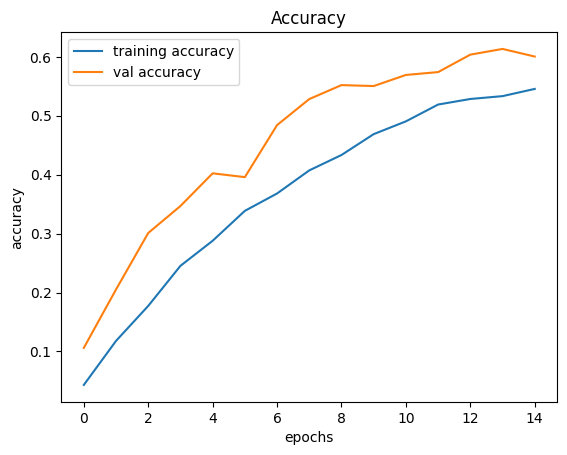

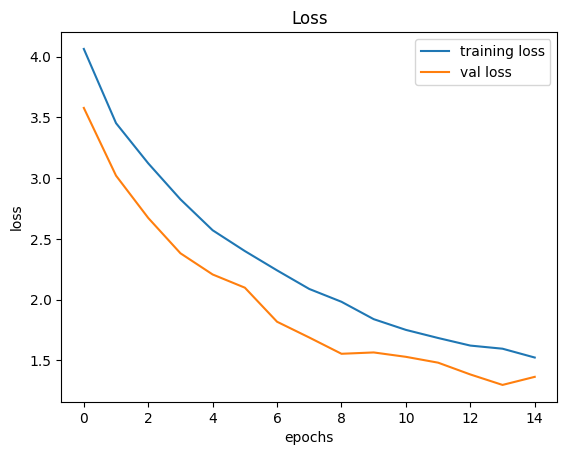

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
test_paths = []
test_labels = []

In [ ]:
os.makedirs(test_path, exist_ok=True)

for filename in os.listdir(test_path):
    file_path = os.path.join(test_path, filename)

    if not os.path.isfile(file_path):
        continue

    match = re.match(pattern, filename)

    if match:
        name = match.group(1).strip().lower()
        if not name in labels:
          print(f"{name}, {labels}")
          continue
        test_paths.append(file_path)
        test_labels.append(name)
    else:
        print(f"Файл не соответствует шаблону: {filename}")

In [ ]:
test_data=[]

for a in test_paths:
  image = Image.open(a)
  image = image.resize((height,width))
  image = np.array(image)
  test_data.append(image)

In [ ]:
enc_test_labels = le.transform(test_labels)

In [ ]:
X_test_pred = np.array(test_data)
X_test_pred = X_test_pred / 255

In [ ]:
start = time.time()
pred_x = model.predict(X_test_pred)
pred = np.argmax(pred_x, axis=1)
end = time.time()

from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(enc_test_labels, pred)*100)
print("Prediction time: ", end-start)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Data accuracy:  63.866666666666674
Prediction time:  0.2878141403198242


In [ ]:
model2 = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(height, width, 3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CATEGORIES, activation='softmax')
])

model2.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 194,027 (757.92 KB)

 Trainable params: 192,875 (753.42 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [ ]:
history2 = model2.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=40, validation_data=(X_test, Y_test), callbacks=callbacks )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0537 - loss: 4.2425

233/233 ━━━━━━━━━━━━━━━━━━━━ 33s 85ms/step - accuracy: 0.0538 - loss: 4.2409 - val_accuracy: 0.0162 - val_loss: 4.9918 - learning_rate: 0.0010
Epoch 2/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1619 - loss: 3.2576

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.1620 - loss: 3.2570 - val_accuracy: 0.1335 - val_loss: 3.5107 - learning_rate: 0.0010
Epoch 3/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2533 - loss: 2.7762

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.2533 - loss: 2.7760 - val_accuracy: 0.2267 - val_loss: 3.0966 - learning_rate: 0.0010
Epoch 4/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3178 - loss: 2.5049

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3178 - loss: 2.5046 - val_accuracy: 0.2881 - val_loss: 2.6742 - learning_rate: 0.0010
Epoch 5/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3575 - loss: 2.2461

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3575 - loss: 2.2461 - val_accuracy: 0.4017 - val_loss: 2.1113 - learning_rate: 0.0010
Epoch 6/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3938 - loss: 2.1471

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3939 - loss: 2.1468 - val_accuracy: 0.4206 - val_loss: 2.0667 - learning_rate: 0.0010
Epoch 7/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.4298 - loss: 1.9845 - val_accuracy: 0.2687 - val_loss: 3.3639 - learning_rate: 0.0010
Epoch 8/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.4726 - loss: 1.8380 - val_accuracy: 0.1599 - val_loss: 5.8194 - learning_rate: 0.0010
Epoch 9/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4995 - loss: 1.7558

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.4994 - loss: 1.7558 - val_accuracy: 0.4976 - val_loss: 1.7470 - learning_rate: 0.0010
Epoch 10/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.5353 - loss: 1.6196 - val_accuracy: 0.3570 - val_loss: 2.5287 - learning_rate: 0.0010
Epoch 11/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5439 - loss: 1.5939 - val_accuracy: 0.4491 - val_loss: 1.9666 - learning_rate: 0.0010
Epoch 12/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.5687 - loss: 1.4770 - val_accuracy: 0.3296 - val_loss: 2.7647 - learning_rate: 0.0010
Epoch 13/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6138 - loss: 1.3371

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6138 - loss: 1.3370 - val_accuracy: 0.6230 - val_loss: 1.2635 - learning_rate: 5.0000e-04
Epoch 14/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6154 - loss: 1.3047 - val_accuracy: 0.6134 - val_loss: 1.3712 - learning_rate: 5.0000e-04
Epoch 15/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6329 - loss: 1.2769

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6329 - loss: 1.2766 - val_accuracy: 0.6457 - val_loss: 1.2478 - learning_rate: 5.0000e-04
Epoch 16/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.6448 - loss: 1.2090 - val_accuracy: 0.6187 - val_loss: 1.2934 - learning_rate: 5.0000e-04
Epoch 17/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.6638 - loss: 1.1802 - val_accuracy: 0.6403 - val_loss: 1.2723 - learning_rate: 5.0000e-04
Epoch 18/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6585 - loss: 1.1570 - val_accuracy: 0.6150 - val_loss: 1.3304 - learning_rate: 5.0000e-04
Epoch 19/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6713 - loss: 1.1187

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6713 - loss: 1.1187 - val_accuracy: 0.7173 - val_loss: 0.9729 - learning_rate: 2.5000e-04
Epoch 20/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6875 - loss: 1.0647 - val_accuracy: 0.6931 - val_loss: 1.0502 - learning_rate: 2.5000e-04
Epoch 21/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.6992 - loss: 1.0408 - val_accuracy: 0.6931 - val_loss: 1.0833 - learning_rate: 2.5000e-04
Epoch 22/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7079 - loss: 1.0142 - val_accuracy: 0.6807 - val_loss: 1.1166 - learning_rate: 2.5000e-04
Epoch 23/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7062 - loss: 0.9808

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7062 - loss: 0.9808 - val_accuracy: 0.7334 - val_loss: 0.9377 - learning_rate: 1.2500e-04
Epoch 24/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7174 - loss: 0.9619 - val_accuracy: 0.7205 - val_loss: 0.9979 - learning_rate: 1.2500e-04
Epoch 25/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7229 - loss: 0.9541 - val_accuracy: 0.7243 - val_loss: 0.9387 - learning_rate: 1.2500e-04
Epoch 26/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7138 - loss: 0.9522 - val_accuracy: 0.7054 - val_loss: 1.0538 - learning_rate: 1.2500e-04
Epoch 27/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7260 - loss: 0.9473

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7259 - loss: 0.9472 - val_accuracy: 0.7313 - val_loss: 0.9299 - learning_rate: 6.2500e-05
Epoch 28/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7338 - loss: 0.9155

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7338 - loss: 0.9156 - val_accuracy: 0.7345 - val_loss: 0.9276 - learning_rate: 6.2500e-05
Epoch 29/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7375 - loss: 0.9116 - val_accuracy: 0.7248 - val_loss: 0.9310 - learning_rate: 6.2500e-05
Epoch 30/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7255 - loss: 0.9201

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7255 - loss: 0.9201 - val_accuracy: 0.7291 - val_loss: 0.9266 - learning_rate: 6.2500e-05
Epoch 31/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7310 - loss: 0.9289

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7310 - loss: 0.9289 - val_accuracy: 0.7437 - val_loss: 0.9012 - learning_rate: 6.2500e-05
Epoch 32/40
232/233 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7393 - loss: 0.8979

233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7392 - loss: 0.8981 - val_accuracy: 0.7604 - val_loss: 0.8416 - learning_rate: 6.2500e-05
Epoch 33/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7342 - loss: 0.9281 - val_accuracy: 0.7404 - val_loss: 0.9134 - learning_rate: 6.2500e-05
Epoch 34/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7293 - loss: 0.9076 - val_accuracy: 0.7561 - val_loss: 0.8797 - learning_rate: 6.2500e-05
Epoch 35/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.7276 - loss: 0.9089 - val_accuracy: 0.7507 - val_loss: 0.8790 - learning_rate: 6.2500e-05
Epoch 36/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7406 - loss: 0.8867 - val_accuracy: 0.7421 - val_loss: 0.8857 - learning_rate: 3.1250e-05
Epoch 37/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7535 - loss: 0.8572 - val_accuracy: 0.7367 - val_loss: 0.9011 - learning_rate: 3.1250e-05
Epoch 38/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - a

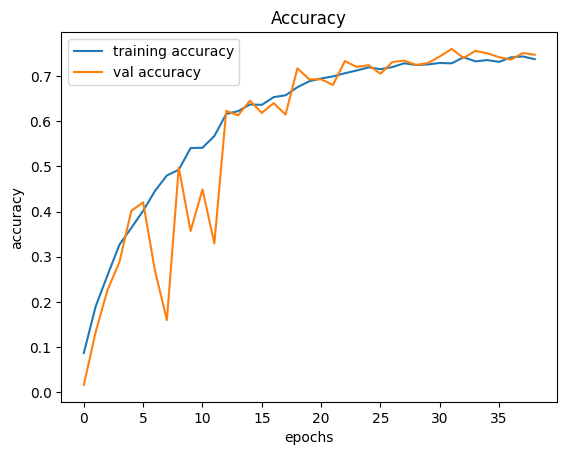

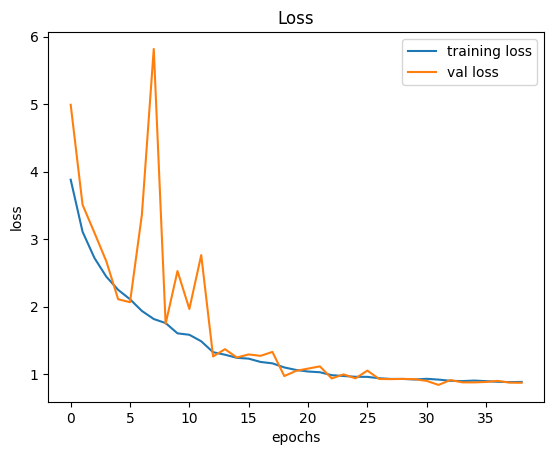

In [ ]:
plt.figure(0)
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
start = time.time()
pred_x_2 = model2.predict(X_test_pred)
pred_2 = np.argmax(pred_x_2, axis=1)
end = time.time()

print('Test Data accuracy: ',accuracy_score(enc_test_labels, pred_2)*100)
print('Prediction time: ', end-start)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Test Data accuracy:  79.60000000000001
Prediction time:  1.986159086227417


In [ ]:
model3 = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(height, width, 3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CATEGORIES, activation='softmax')
])

model3.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model3.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 16, 16, 128)    │             

 Total params: 284,459 (1.09 MB)

 Trainable params: 282,667 (1.08 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
aug2 = ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

In [ ]:
history3 = model3.fit(aug2.flow(X_train,Y_train,batch_size=32),
                    epochs=40, validation_data=(X_test, Y_test), callbacks=callbacks )

Epoch 1/40
  1/233 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.5938 - loss: 1.0415

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.7688 - loss: 0.7573 - val_accuracy: 0.7297 - val_loss: 0.9486 - learning_rate: 6.2500e-05
Epoch 2/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7864 - loss: 0.6952 - val_accuracy: 0.7544 - val_loss: 0.8896 - learning_rate: 6.2500e-05
Epoch 3/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7835 - loss: 0.7219 - val_accuracy: 0.7474 - val_loss: 0.9117 - learning_rate: 6.2500e-05
Epoch 4/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7915 - loss: 0.6851 - val_accuracy: 0.7474 - val_loss: 0.9111 - learning_rate: 6.2500e-05
Epoch 5/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.7898 - loss: 0.7029 - val_accuracy: 0.7442 - val_loss: 0.8973 - learning_rate: 6.2500e-05
Epoch 6/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8043 - loss: 0.6769 - val_accuracy: 0.7614 - val_loss: 0.8508 - learning_rate: 3.1250e-05
Epoch 7/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accurac

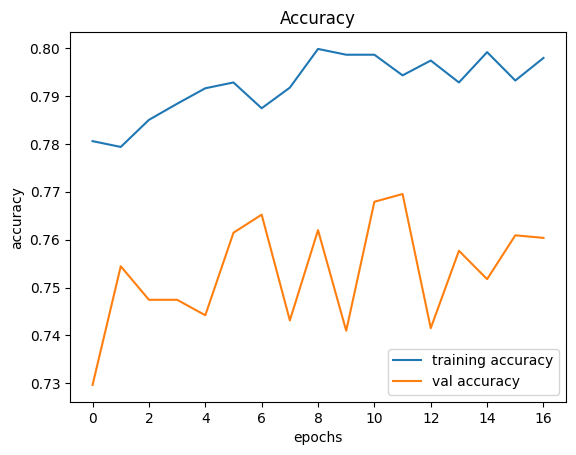

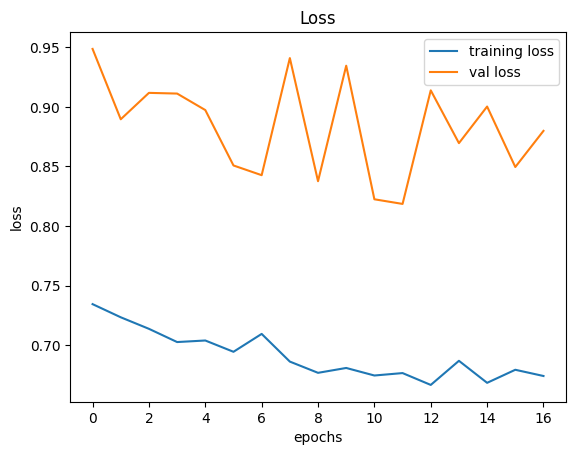

In [ ]:
plt.figure(0)
plt.plot(history3.history['accuracy'], label='training accuracy')
plt.plot(history3.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history3.history['loss'], label='training loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
start = time.time()
pred_x_3 = model3.predict(X_test_pred)
pred_3 = np.argmax(pred_x_3, axis=1)
end = time.time()

from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(enc_test_labels, pred_3)*100)
print('Prediction time: ', end-start)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Data accuracy:  80.0
Prediction time:  0.3714108467102051


In [ ]:
model4 = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(height, width, 3)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),

    # Conv2D(512, (3,3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),

    # Conv2D(512, (3,3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),

    # Conv2D(512, (3,3), padding='same'),
    # BatchNormalization(),
    # Activation('relu'),
    # MaxPool2D((2,2)),
    # Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CATEGORIES, activation='softmax')
])

model4.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model4.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 28, 28, 128)    │             

 Total params: 2,087,403 (7.96 MB)

 Trainable params: 2,083,691 (7.95 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
aug3 = ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode="nearest")

In [ ]:
history4 = model4.fit(aug2.flow(X_train,Y_train,batch_size=32),
                   epochs=60, validation_data=(X_test, Y_test), callbacks=callbacks )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.0541 - loss: 4.3024

233/233 ━━━━━━━━━━━━━━━━━━━━ 64s 185ms/step - accuracy: 0.0542 - loss: 4.3009 - val_accuracy: 0.0162 - val_loss: 5.6639 - learning_rate: 0.0010
Epoch 2/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1409 - loss: 3.4139

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.1410 - loss: 3.4134 - val_accuracy: 0.0819 - val_loss: 5.1529 - learning_rate: 0.0010
Epoch 3/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2214 - loss: 2.9218

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.2214 - loss: 2.9217 - val_accuracy: 0.1341 - val_loss: 4.9348 - learning_rate: 0.0010
Epoch 4/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2994 - loss: 2.5212

233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.2995 - loss: 2.5210 - val_accuracy: 0.3005 - val_loss: 2.8549 - learning_rate: 0.0010
Epoch 5/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3512 - loss: 2.2702

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.3512 - loss: 2.2701 - val_accuracy: 0.3258 - val_loss: 2.7325 - learning_rate: 0.0010
Epoch 6/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.4102 - loss: 2.0812 - val_accuracy: 0.3274 - val_loss: 2.8965 - learning_rate: 0.0010
Epoch 7/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.4484 - loss: 1.8967 - val_accuracy: 0.1675 - val_loss: 6.6993 - learning_rate: 0.0010
Epoch 8/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.4644 - loss: 1.8348 - val_accuracy: 0.3204 - val_loss: 3.0434 - learning_rate: 0.0010
Epoch 9/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5583 - loss: 1.5211

233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.5583 - loss: 1.5210 - val_accuracy: 0.5913 - val_loss: 1.3830 - learning_rate: 5.0000e-04
Epoch 10/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5708 - loss: 1.4702

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.5709 - loss: 1.4700 - val_accuracy: 0.6279 - val_loss: 1.2391 - learning_rate: 5.0000e-04
Epoch 11/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.6003 - loss: 1.3560 - val_accuracy: 0.6004 - val_loss: 1.3671 - learning_rate: 5.0000e-04
Epoch 12/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.6050 - loss: 1.3206 - val_accuracy: 0.4513 - val_loss: 2.1122 - learning_rate: 5.0000e-04
Epoch 13/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6182 - loss: 1.2998

233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.6183 - loss: 1.2996 - val_accuracy: 0.6591 - val_loss: 1.2243 - learning_rate: 5.0000e-04
Epoch 14/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.6344 - loss: 1.2386 - val_accuracy: 0.5396 - val_loss: 1.6453 - learning_rate: 5.0000e-04
Epoch 15/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6598 - loss: 1.1195

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.6598 - loss: 1.1196 - val_accuracy: 0.7324 - val_loss: 0.9518 - learning_rate: 5.0000e-04
Epoch 16/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.6765 - loss: 1.0796 - val_accuracy: 0.7017 - val_loss: 1.0732 - learning_rate: 5.0000e-04
Epoch 17/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.6912 - loss: 1.0321 - val_accuracy: 0.7167 - val_loss: 0.9629 - learning_rate: 5.0000e-04
Epoch 18/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.7079 - loss: 0.9841 - val_accuracy: 0.7146 - val_loss: 0.9661 - learning_rate: 5.0000e-04
Epoch 19/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7356 - loss: 0.8814

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.7356 - loss: 0.8813 - val_accuracy: 0.7555 - val_loss: 0.8422 - learning_rate: 2.5000e-04
Epoch 20/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7484 - loss: 0.8465

233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.7484 - loss: 0.8465 - val_accuracy: 0.7625 - val_loss: 0.8037 - learning_rate: 2.5000e-04
Epoch 21/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.7468 - loss: 0.8418 - val_accuracy: 0.7636 - val_loss: 0.8073 - learning_rate: 2.5000e-04
Epoch 22/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.7589 - loss: 0.7936 - val_accuracy: 0.7555 - val_loss: 0.8656 - learning_rate: 2.5000e-04
Epoch 23/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - accuracy: 0.7668 - loss: 0.7728 - val_accuracy: 0.7663 - val_loss: 0.8245 - learning_rate: 2.5000e-04
Epoch 24/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7730 - loss: 0.7580

233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.7730 - loss: 0.7579 - val_accuracy: 0.8045 - val_loss: 0.6527 - learning_rate: 1.2500e-04
Epoch 25/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7825 - loss: 0.7088

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.7825 - loss: 0.7088 - val_accuracy: 0.8110 - val_loss: 0.6442 - learning_rate: 1.2500e-04
Epoch 26/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8053 - loss: 0.6592

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.8053 - loss: 0.6594 - val_accuracy: 0.8201 - val_loss: 0.6027 - learning_rate: 1.2500e-04
Epoch 27/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.8002 - loss: 0.6661 - val_accuracy: 0.8218 - val_loss: 0.6402 - learning_rate: 1.2500e-04
Epoch 28/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7983 - loss: 0.6669

233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.7982 - loss: 0.6669 - val_accuracy: 0.8266 - val_loss: 0.5930 - learning_rate: 1.2500e-04
Epoch 29/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - accuracy: 0.8096 - loss: 0.6599 - val_accuracy: 0.8137 - val_loss: 0.6404 - learning_rate: 1.2500e-04
Epoch 30/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 116ms/step - accuracy: 0.8110 - loss: 0.6419 - val_accuracy: 0.8212 - val_loss: 0.6203 - learning_rate: 1.2500e-04
Epoch 31/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.8109 - loss: 0.6395 - val_accuracy: 0.8191 - val_loss: 0.6347 - learning_rate: 1.2500e-04
Epoch 32/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.8252 - loss: 0.6004 - val_accuracy: 0.8250 - val_loss: 0.6106 - learning_rate: 6.2500e-05
Epoch 33/60
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.8248 - loss: 0.5927 - val_accuracy: 0.8164 - val_loss: 0.6233 - learning_rate: 6.2500e-05


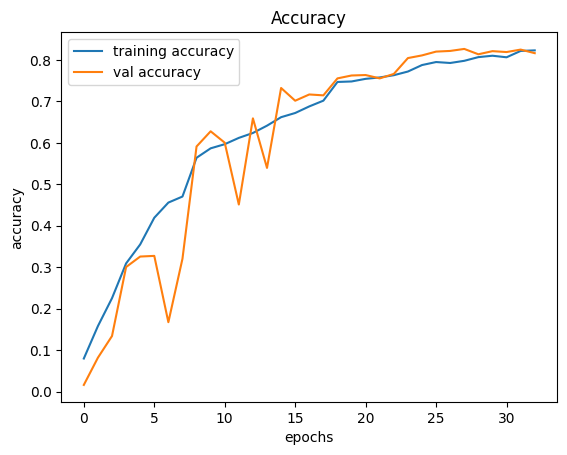

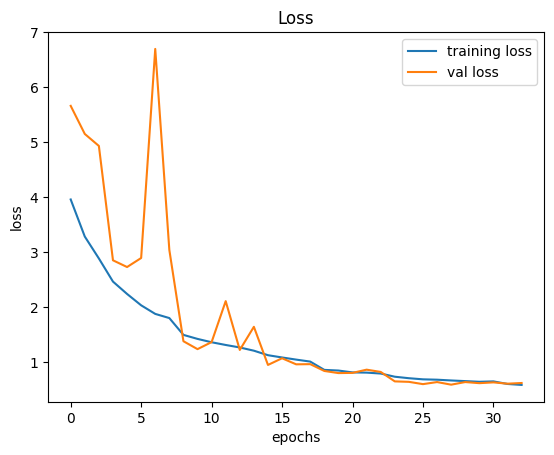

In [ ]:
plt.figure(0)
plt.plot(history4.history['accuracy'], label='training accuracy')
plt.plot(history4.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history4.history['loss'], label='training loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
start = time.time()
pred_x_4 = model4.predict(X_test_pred)
pred_4 = np.argmax(pred_x_4, axis=1)
end = time.time()

from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(enc_test_labels, pred_4)*100)
print('Prediction time: ', end-start)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
Test Data accuracy:  84.39999999999999
Prediction time:  3.195188522338867
